# HSE 2021: Mathematical Methods for Data Analysis

## Homework 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
import sys
from statsmodels.tools.eval_measures import rmse

from sklearn import datasets
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from tqdm.notebook import trange, tqdm
%matplotlib inline

sns.set(style="darkgrid")
np.random.seed(100)

### Data

For this homework we use Boston Dataset from sklearn (based on UCI ML housing dataset).

In [2]:
data = load_boston() # load dataset

X = data.data
y = data.target
columns = data.feature_names

## Linear regression

#### 1. [0.5 points] Create Pandas DataFrame and split the data into train and test sets with ratio 80:20 with random_state=0.

In [3]:
df = pd.DataFrame(X, columns=columns)
df['target'] = y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

old_X_train = X_train
old_X_test = X_test
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


#### 2. [1 point] Train models on train data using StatsModels library and apply it to the test set; use $RMSE$ and $R^2$ as the quality measure.

* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with $\alpha = 0.01$;
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) with $\alpha = 0.01$

Don't forget to scale the data before training the models with StandardScaler!

In [4]:
def custom_scale(X_train, X_test):
    scaler = StandardScaler()
    return (sm.add_constant(scaler.fit_transform(X_train)), sm.add_constant(scaler.transform(X_test)))

X_train, X_test = custom_scale(old_X_train, old_X_test)

alpha = 0.01
p_value = 0.05

In [5]:
def show_rmse(model):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))
    print("Test RMSE = %.4f" % rmse(y_test, y_pred))

In [6]:
# Linear
linear_model = sm.OLS(y_train, X_train)
linear_results = linear_model.fit()

show_rmse(linear_results)

Train RMSE = 4.3962
Test RMSE = 5.7835


In [7]:
# Ridge
ridge_model = linear_model.fit_regularized(alpha=alpha, L1_wt=0)
ridge_results = sm.regression.linear_model.OLSResults(linear_model, ridge_model.params, linear_model.normalized_cov_params)

show_rmse(ridge_results)

Train RMSE = 4.4039
Test RMSE = 5.8270


In [8]:
# Lasso
lasso_model = linear_model.fit_regularized(alpha=alpha, L1_wt=1)
lasso_results = sm.regression.linear_model.OLSResults(linear_model, lasso_model.params, linear_model.normalized_cov_params)

show_rmse(lasso_results)

Train RMSE = 4.3968
Test RMSE = 5.7962


#### 3. [1 point] Explore the values of the parameters of the resulting models and compare the number of zero weights in them. Comment on the significance of the coefficients, overal model significance and other related factors from the results table

# The significance level

The P-Value as you know provides probability of the hypothesis test,So in a regression model the P-Value for each independent variable tests the Null Hypothesis that there is “No Correlation” between the independent and the dependent variable,this also helps to determine the relationship observed in the sample also exists in the larger data.
So if the P-Value is less than the significance level (usually 0.05) then your model fits the data well.

The significance level is the probability of rejecting the null hypothesis when it is true.

For the models above all coeff-s which have **p-value > 0,05** will be dropped.

# R² score

As for the R² metric, it measures the proportion of variability in the target that can be explained using a feature X. Therefore, assuming a linear relationship, if feature X can explain (predict) the target, then the proportion is high and the R² value will be close to 1. If the opposite is true, the R² value is then closer to 0.

### Statsmodel

For calculations statsmodel.api will be used. As for **R²** score calculation, **Adj. R-squared** will be used, as **R-squared** is biased.

In [9]:
def get_str_repr(x):
    if x > 0:
        return f"+ {x} "
    else:
        return f" {x} "

def get_coef_str(a, i):
    return f"{get_str_repr(a)} \cdot x_{i} "

def get_equation(results):
    coeffs = {}
    
    for i in range(len(results.pvalues)):
        if results.pvalues[i] <= p_value:
            coeffs[i] = round(results.params[i], 5)

    latex = ""
    for i in coeffs:
        if i == 0:
            latex += f" {coeffs[i]} "
        else:
            latex += get_coef_str(coeffs[i], i)
    
    return f"$y = {latex} $"
    

In [10]:
linear_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.765    
Dependent Variable: y                AIC:                2370.9385
Date:               2021-03-12 14:40 BIC:                2426.9583
No. Observations:   404              Log-Likelihood:     -1171.5  
Df Model:           13               F-statistic:        102.2    
Df Residuals:       390              Prob (F-statistic): 9.64e-117
R-squared:          0.773            Scale:              20.020   
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const     22.6119     0.2226   101.5764   0.0000   22.1742   23.0495
x1        -0.9708     0.2980    -3.2575   0.0012   -1.5568   -0.3849
x2         1.0571     0.3408     3.1022   0.0021    0.3872    1.7271
x3         0.0383     0.4428     0.0865   0.9311   -0.8324    0.9090
x4         0.5945     0.2291     2.5946   0.0098    0.1440    1.0450
x5        -1.8551     0.4846    -3.8282   0.0002   -2.8079   -0.9024
x6         2.5732     0.3175     8.1058   0.0000    1.9491    3.1974
x7        -0.0876     0.4022    -0.2178   0.8277   -0.8784    0.7032
x8        -2.8809     0.4446    -6.4800   0.0000   -3.7550   -2.0068
x9         2.1122     0.6069     3.4805   0.0006    0.9191    3.3054
x10       -1.8753     0.6652    -2.8191   0.0051   -3.1832   -0.5675
x11       -2.2928     0.3003    -7.6359   0.0000   -2.8831   -1.7024
x12        0.7182     0.2613     2.7486   0.0063    0.2045    1.2319
x13       -3.5925     0.3954    -9.0855   0.0000   -4.3698   -2.8151
------------------------------------------------------------------
Omnibus:             141.494       Durbin-Watson:          1.996  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       629.882
Skew:                1.470         Prob(JB):               0.000  
Kurtosis:            8.365         Condition No.:          10     
==================================================================

"""

In [11]:
print(get_equation(linear_results))

$y =  22.61188  -0.97082  \cdot x_1 + 1.05715  \cdot x_2 + 0.59451  \cdot x_4  -1.85515  \cdot x_5 + 2.57322  \cdot x_6  -2.88094  \cdot x_8 + 2.11225  \cdot x_9  -1.87533  \cdot x_10  -2.29277  \cdot x_11 + 0.71818  \cdot x_12  -3.59245  \cdot x_13  $


### Predicted equation

$y =  22.61188  -0.97082  \cdot x_1 + 1.05715  \cdot x_2 + 0.59451  \cdot x_4  -1.85515  \cdot x_5 + 2.57322  \cdot x_6  -2.88094  \cdot x_8 + 2.11225  \cdot x_9  -1.87533  \cdot x_10  -2.29277  \cdot x_11 + 0.71818  \cdot x_12  -3.59245  \cdot x_13  $

In [12]:
ridge_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.765    
Dependent Variable: y                AIC:                2372.3540
Date:               2021-03-12 14:40 BIC:                2428.3738
No. Observations:   404              Log-Likelihood:     -1172.2  
Df Model:           13               F-statistic:        101.7    
Df Residuals:       390              Prob (F-statistic): 1.90e-116
R-squared:          0.772            Scale:              20.091   
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const     22.3880     0.2230   100.3946   0.0000   21.9496   22.8264
x1        -0.9389     0.2986    -3.1449   0.0018   -1.5259   -0.3519
x2         0.9965     0.3414     2.9190   0.0037    0.3253    1.6676
x3        -0.0576     0.4436    -0.1298   0.8968   -0.9298    0.8146
x4         0.6098     0.2295     2.6566   0.0082    0.1585    1.0611
x5        -1.7222     0.4854    -3.5477   0.0004   -2.6766   -0.7678
x6         2.6120     0.3180     8.2135   0.0000    1.9868    3.2372
x7        -0.1155     0.4029    -0.2867   0.7745   -0.9078    0.6767
x8        -2.7539     0.4454    -6.1834   0.0000   -3.6295   -1.8783
x9         1.8348     0.6079     3.0181   0.0027    0.6396    3.0301
x10       -1.6265     0.6664    -2.4407   0.0151   -2.9366   -0.3163
x11       -2.2561     0.3008    -7.5007   0.0000   -2.8475   -1.6648
x12        0.7188     0.2617     2.7463   0.0063    0.2042    1.2334
x13       -3.5287     0.3961    -8.9086   0.0000   -4.3074   -2.7499
------------------------------------------------------------------
Omnibus:             147.660       Durbin-Watson:          1.990  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       694.793
Skew:                1.521         Prob(JB):               0.000  
Kurtosis:            8.659         Condition No.:          10     
==================================================================

"""

In [13]:
print(get_equation(ridge_results))

$y =  22.388  -0.93892  \cdot x_1 + 0.99647  \cdot x_2 + 0.60978  \cdot x_4  -1.72221  \cdot x_5 + 2.612  \cdot x_6  -2.75391  \cdot x_8 + 1.83481  \cdot x_9  -1.62648  \cdot x_10  -2.25612  \cdot x_11 + 0.71883  \cdot x_12  -3.52866  \cdot x_13  $


### Predicted equation

$y =  22.388  -0.93892  \cdot x_1 + 0.99647  \cdot x_2 + 0.60978  \cdot x_4  -1.72221  \cdot x_5 + 2.612  \cdot x_6  -2.75391  \cdot x_8 + 1.83481  \cdot x_9  -1.62648  \cdot x_10  -2.25612  \cdot x_11 + 0.71883  \cdot x_12  -3.52866  \cdot x_13  $

In [14]:
lasso_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.765    
Dependent Variable: y                AIC:                2371.0439
Date:               2021-03-12 14:40 BIC:                2427.0637
No. Observations:   404              Log-Likelihood:     -1171.5  
Df Model:           13               F-statistic:        102.1    
Df Residuals:       390              Prob (F-statistic): 1.01e-116
R-squared:          0.773            Scale:              20.025   
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const     22.6019     0.2226   101.5182   0.0000   22.1642   23.0396
x1        -0.9403     0.2981    -3.1547   0.0017   -1.5263   -0.3543
x2         1.0215     0.3408     2.9972   0.0029    0.3514    1.6916
x3         0.0000     0.4429     0.0000   1.0000   -0.8708    0.8708
x4         0.5948     0.2292     2.5955   0.0098    0.1442    1.0453
x5        -1.8029     0.4847    -3.7200   0.0002   -2.7558   -0.8500
x6         2.5852     0.3175     8.1423   0.0000    1.9609    3.2094
x7        -0.0690     0.4023    -0.1715   0.8639   -0.8599    0.7220
x8        -2.8085     0.4446    -6.3162   0.0000   -3.6827   -1.9343
x9         1.9567     0.6070     3.2238   0.0014    0.7634    3.1501
x10       -1.7392     0.6653    -2.6141   0.0093   -3.0472   -0.4311
x11       -2.2788     0.3003    -7.5884   0.0000   -2.8692   -1.6884
x12        0.7056     0.2613     2.7000   0.0072    0.1918    1.2193
x13       -3.5969     0.3955    -9.0956   0.0000   -4.3744   -2.8194
------------------------------------------------------------------
Omnibus:             143.585       Durbin-Watson:          1.997  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       649.888
Skew:                1.488         Prob(JB):               0.000  
Kurtosis:            8.455         Condition No.:          10     
==================================================================

"""

In [15]:
print(get_equation(lasso_results))

$y =  22.60188  -0.94032  \cdot x_1 + 1.0215  \cdot x_2 + 0.59479  \cdot x_4  -1.80292  \cdot x_5 + 2.58517  \cdot x_6  -2.80847  \cdot x_8 + 1.95673  \cdot x_9  -1.73918  \cdot x_10  -2.27881  \cdot x_11 + 0.70557  \cdot x_12  -3.59692  \cdot x_13  $


### Predicted equation

$y =  22.60188  -0.94032  \cdot x_1 + 1.0215  \cdot x_2 + 0.59479  \cdot x_4  -1.80292  \cdot x_5 + 2.58517  \cdot x_6  -2.80847  \cdot x_8 + 1.95673  \cdot x_9  -1.73918  \cdot x_10  -2.27881  \cdot x_11 + 0.70557  \cdot x_12  -3.59692  \cdot x_13  $

# Conlusion
It can be seen that in all three models, share common characteristics. As for significant coeffs, $x_3$ and $x_7$ were dropped. As for $R^2$ score, they have the same Adj. R-squared:	0.765. Therefore, more than 76% of variability in the target that can be explained using a feature X. This is good, but definitely not the best we can to accurately predict the target.

#### 4. [1 point] Implement one of the elimination algorithms that were described in the Seminar_4 (Elimination by P-value, Forward elimination, Backward elimination), make conclusions.

In [16]:
def eliminate_by_p_value(y, X, alpha):
    y, X = y.copy(), X.copy(), 
    
    while True:
        results = sm.OLS(y, X).fit()
        p_values = results.pvalues

        if len(p_values[p_values > alpha]) == 0:
            break;
            
        index = np.argmax(p_values)
        X = np.delete(X, index, axis=1)
        
    return results
    
elimination_results = eliminate_by_p_value(y_train, X_train, p_value)
elimination_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.767    
Dependent Variable: y                AIC:                2366.9962
Date:               2021-03-12 14:40 BIC:                2415.0132
No. Observations:   404              Log-Likelihood:     -1171.5  
Df Model:           11               F-statistic:        121.3    
Df Residuals:       392              Prob (F-statistic): 8.15e-119
R-squared:          0.773            Scale:              19.921   
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const     22.6119     0.2221   101.8292   0.0000   22.1753   23.0485
x1        -0.9694     0.2969    -3.2652   0.0012   -1.5531   -0.3857
x2         1.0657     0.3349     3.1817   0.0016    0.4072    1.7242
x3         0.5950     0.2276     2.6145   0.0093    0.1476    1.0425
x4        -1.8752     0.4455    -4.2092   0.0000   -2.7511   -0.9993
x5         2.5571     0.3092     8.2693   0.0000    1.9492    3.1651
x6        -2.8621     0.4144    -6.9062   0.0000   -3.6768   -2.0473
x7         2.1039     0.5729     3.6725   0.0003    0.9776    3.2302
x8        -1.8509     0.5893    -3.1410   0.0018   -3.0094   -0.6924
x9        -2.2922     0.2953    -7.7616   0.0000   -2.8729   -1.7116
x10        0.7116     0.2591     2.7460   0.0063    0.2021    1.2211
x11       -3.6205     0.3676    -9.8482   0.0000   -4.3433   -2.8977
------------------------------------------------------------------
Omnibus:             140.146       Durbin-Watson:          1.999  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       614.839
Skew:                1.459         Prob(JB):               0.000  
Kurtosis:            8.292         Condition No.:          8      
==================================================================

"""

#### 5. [1 point] Find the best (in terms of RMSE) $\alpha$ for Ridge regression using cross-validation with 5 folds. You must select values from range $[10^{-4}, 10^{3}]$.

In [17]:
# ridge_model = linear_model.fit_regularized(alpha=alpha, L1_wt=0)
# ridge_results = sm.regression.linear_model.OLSResults(linear_model, ridge_model.params, linear_model.normalized_cov_params)

class SMRidgeWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class):
        self.model_class = model_class
    def fit(self, X, y):
        self.linear_model_ = self.model_class(y, X)
        self.model_ = self.linear_model_.fit_regularized(alpha=alpha, L1_wt=0)
        self.results_ = sm.regression.linear_model.OLSResults(linear_model, ridge_model.params, linear_model.normalized_cov_params)
        return self.results_
    def predict(self, X):
        return self.results_.predict(X)

In [18]:
cv_scores = cross_val_score(SMRidgeWrapper(sm.OLS), X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % -x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 14.6024
	19.1293
	18.9876
	30.2033
	13.9822
Mean CV MSE = 19.3809


Best alpha = 10.1011


Text(0, 0.5, 'CV score')

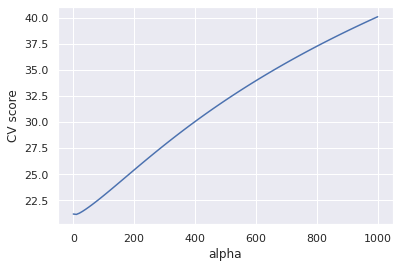

In [19]:
alphas = np.linspace(0.0001, 1000, 100)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_mean_squared_error", cv=5)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xlabel("alpha")
plt.ylabel("CV score")

## Gradient descent

#### 6. [3.5 points] Implement a linear regression model for the MSE loss function, trained by gradient descent.

All calculations must be vectorized, and python loops can only be used for gradient descent iterations. As a stop criterion, you must use (simultaneously):

* checking for the Euclidean norm of the weight difference on two adjacent iterations (for example, less than some small number of the order of $10^{-6}$, set by the `tolerance` parameter);
* reaching the maximum number of iterations (for example, 10000, set by the `max_iter` parameter).

You need to implement:

* Full gradient descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

* Stochastic Gradient Descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$

$\nabla_{w} q_{i_{k}}(w_{k}) \, $ is the estimate of the gradient over the butch of objects selected randomly.

* Momentum method:

$$
h_0 = 0, \\
h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
w_{k + 1} = w_{k} - h_{k + 1}.
$$


To make sure that the optimization process really converges, we will use the `loss_history` class attribute. After calling the `fit` method, it should contain the values of the loss function for all iterations, starting from the first one (before the first step on the anti-gradient).

You need to initialize the weights with a zero or random (from a normal distribution) vector. The following is a template class that needs to contain the code implementing all variations of the models.

In [29]:
from sklearn.base import BaseEstimator

"""
As there is not option for adding constants to X (ones), this Linear Regression implementation assume that X is already had constants added.
"""

class LinReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='Momentum', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, alpha=1e-3):
        """
        gd_type: 'GradientDescent', 'StochasticDescent', 'Momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        
        if gd_type != 'GradientDescent' and gd_type != 'StochasticDescent' and gd_type != 'Momentum':
            raise Exception('Unknown GD type')
        
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.batch_size = 1
        self.moment = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        if self.w0 is None:
            self.w0 = np.zeros(X.shape[1])
        else:
            self.w0 = np.append(self.w0, [[0]])
            self.w0 = np.array(self.w0)
            
        self.w0 = np.array([self.w0])

        self.w = self.w0
        prev_w = self.w0
        
        self.loss_history.append(self.calc_loss(X, y))
        self.w = self.step(X, y)
        
        for iter_num in trange(1, self.max_iter + 1):
            self.iter = iter_num
            
            if np.linalg.norm(self.w - prev_w) < self.tolerance:
                print("Reached tolerance")
                return self
                
            new_w = self.step(X, y)
            prev_w = self.w
            self.w = new_w
            
            self.loss_history.append(self.calc_loss(X, y))

        return self
    
    def step(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: np.array of shape (l)
        """
        
        gradient = self.calc_gradient(X, y)
        
        if self.gd_type == 'Momentum':        
            columns = X.shape[1]
            
            if self.moment is None:
                self.moment = np.zeros((1, columns))
                
            new_moment = self.alpha * self.moment + self.eta * gradient
            self.moment = new_moment
            new_w = self.w - self.moment
        else:
            new_w = self.w - self.eta * gradient

        return new_w
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        y_pred = X.dot(self.w.T).T
        y_pred = np.ravel(y_pred)
        
        return y_pred
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        
        if self.gd_type == 'GradientDescent':
            _y = np.array([y]).T
            _X = X
        else:
            rows = X.shape[0]
            random_rows = np.random.randint(rows, size=self.batch_size)
            
            _X = X[random_rows]
            _y = np.array([y]).T[random_rows]

        gradient = 2 * _X.T.dot(_X.dot(self.w.T) - _y).T / _X.shape[0]
        
        return gradient

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """
        
        y_pred = self.predict(X)
        loss = mean_squared_error(y_pred.ravel(), y)
        
        return loss

#### 7. [1 points] Train and validate "hand-written" models on the same data, and compare the quality with the Sklearn or StatsModels methods. Investigate the effect of the `max_iter` and `alpha` parameters on the optimization process. Is it consistent with your expectations?

In [30]:
alphas = np.linspace(0.0001, 0.5, 10)
max_iters = [10 ** i for i in range(3, 9)]

for max_iter in max_iters:
    print(f"Custom regression with max_iter={max_iter}\n")
    
    custom_model = LinReg(max_iter=max_iter)
    custom_model.fit(X_train, y_train)
    
    show_rmse(custom_model)
    print()
    
for alpha in alphas:
    print(f"Custom regression with alpha={alpha}\n")
    
    custom_model = LinReg(alpha=alpha)
    custom_model.fit(X_train, y_train)
    
    show_rmse(custom_model)
    print()

Custom regression with max_iter=1000



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 4.5792
Test RMSE = 5.5497

Custom regression with max_iter=10000



  0%|          | 0/10000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.5423
Test RMSE = 5.7522

Custom regression with max_iter=100000



  0%|          | 0/100000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.6011
Test RMSE = 6.0963

Custom regression with max_iter=1000000



  0%|          | 0/1000000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.6535
Test RMSE = 6.4022

Custom regression with max_iter=10000000



  0%|          | 0/10000000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 5.0895
Test RMSE = 5.8063

Custom regression with max_iter=100000000



  0%|          | 0/100000000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.5952
Test RMSE = 5.9871

Custom regression with alpha=0.0001



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 4.5887
Test RMSE = 6.2124

Custom regression with alpha=0.05564444444444445



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 4.7904
Test RMSE = 5.8619

Custom regression with alpha=0.11118888888888889



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 4.9534
Test RMSE = 6.3816

Custom regression with alpha=0.16673333333333332



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 5.0870
Test RMSE = 5.9935

Custom regression with alpha=0.22227777777777777



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 5.1675
Test RMSE = 7.0465

Custom regression with alpha=0.2778222222222222



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 7.0608
Test RMSE = 7.5074

Custom regression with alpha=0.33336666666666664



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 5.4482
Test RMSE = 6.8609

Custom regression with alpha=0.3889111111111111



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 4.6726
Test RMSE = 6.1537

Custom regression with alpha=0.44445555555555555



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 4.4940
Test RMSE = 5.9570

Custom regression with alpha=0.5



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 6.4169
Test RMSE = 8.8772



It can be seen that incrementing max_iter can make model worse. As for random selection, nothing is fixed.

As for alpha, it can be seen that it makes model worse, than better and so on, its unpredictable, what could be.

Lets try full gradient to exclude randomness.

### Note

The comprasion of loss function values were done in step 8. As for this one I am creating model over and over, as for geting rmse for test data will not work as weights will be overwriten.

In [22]:
for max_iter in max_iters:
    print(f"Custom regression with max_iter={max_iter}\n")
    
    custom_model = LinReg(gd_type='GradientDescent', max_iter=max_iter)
    custom_model.fit(X_train, y_train)
    
    show_rmse(custom_model)
    print()

Custom regression with max_iter=1000



  0%|          | 0/1000 [00:00<?, ?it/s]

Train RMSE = 4.4013
Test RMSE = 5.8215

Custom regression with max_iter=10000



  0%|          | 0/10000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.3962
Test RMSE = 5.7862

Custom regression with max_iter=100000



  0%|          | 0/100000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.3962
Test RMSE = 5.7862

Custom regression with max_iter=1000000



  0%|          | 0/1000000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.3962
Test RMSE = 5.7862

Custom regression with max_iter=10000000



  0%|          | 0/10000000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.3962
Test RMSE = 5.7862

Custom regression with max_iter=100000000



  0%|          | 0/100000000 [00:00<?, ?it/s]

Reached tolerance
Train RMSE = 4.3962
Test RMSE = 5.7862



Nothing changed, so it can be assumed that Full Gradients does not depend on iterations count. But may be this assumption is correct for max_iter higher than 1000. Lets check for lower ones.

In [23]:
for max_iter in range(1, 1001, 100):
    print(f"Custom regression with max_iter={max_iter}\n")
    
    custom_model = LinReg(max_iter=max_iter)
    custom_model.fit(X_train, y_train)
    
    show_rmse(custom_model)
    print()

Custom regression with max_iter=1



  0%|          | 0/1 [00:00<?, ?it/s]

Train RMSE = 23.0395
Test RMSE = 22.9102

Custom regression with max_iter=101



  0%|          | 0/101 [00:00<?, ?it/s]

Train RMSE = 7.1437
Test RMSE = 8.4033

Custom regression with max_iter=201



  0%|          | 0/201 [00:00<?, ?it/s]

Train RMSE = 4.8622
Test RMSE = 6.4731

Custom regression with max_iter=301



  0%|          | 0/301 [00:00<?, ?it/s]

Train RMSE = 5.3636
Test RMSE = 7.0845

Custom regression with max_iter=401



  0%|          | 0/401 [00:00<?, ?it/s]

Train RMSE = 5.2983
Test RMSE = 7.1633

Custom regression with max_iter=501



  0%|          | 0/501 [00:00<?, ?it/s]

Train RMSE = 4.9258
Test RMSE = 5.8982

Custom regression with max_iter=601



  0%|          | 0/601 [00:00<?, ?it/s]

Train RMSE = 5.2384
Test RMSE = 6.6958

Custom regression with max_iter=701



  0%|          | 0/701 [00:00<?, ?it/s]

Train RMSE = 4.8781
Test RMSE = 6.4681

Custom regression with max_iter=801



  0%|          | 0/801 [00:00<?, ?it/s]

Train RMSE = 4.8344
Test RMSE = 5.9933

Custom regression with max_iter=901



  0%|          | 0/901 [00:00<?, ?it/s]

Train RMSE = 4.6755
Test RMSE = 6.2997



It can be seen, taht RMSE is changing, so Full gradient will depend on max_iter but after some value it will not.

#### 8. [1 points] Plot graphs (on the same picture) of the dependence of the loss function value on the iteration number for Full GD, SGD and Momentum. Draw conclusions about the rate of convergence of various modifications of gradient descent.

Don't forget about what *beautiful* graphics should look like!

In [24]:
labels = ['GradientDescent', 'StochasticDescent', 'Momentum']
values = {}
MAX_ITER_DEG = 9

for i in range(len(labels)):
    values[labels[i]] = []
    custom_model = LinReg(gd_type = labels[i], max_iter=10 ** MAX_ITER_DEG)
    custom_model.fit(X_train, y_train)
    for j in range(1, 10**(MAX_ITER_DEG - 1) + 1, 10):
        if j >= len(custom_model.loss_history):
            loss = custom_model.loss_history[-1]
        else:
            loss = custom_model.loss_history[j]
        values[labels[i]].append(loss)

  0%|          | 0/1000000000 [00:00<?, ?it/s]

Reached tolerance


  0%|          | 0/1000000000 [00:00<?, ?it/s]

Reached tolerance


  0%|          | 0/1000000000 [00:00<?, ?it/s]

Reached tolerance


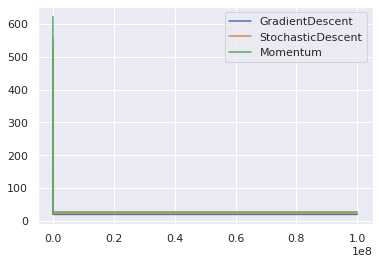

In [25]:
plt.figure()
for i in range(len(labels)):
    plt.plot([i for i in range(1, 10**(MAX_ITER_DEG - 1) + 1, 10)], values[labels[i]], label=labels[i])

plt.legend()
plt.show()

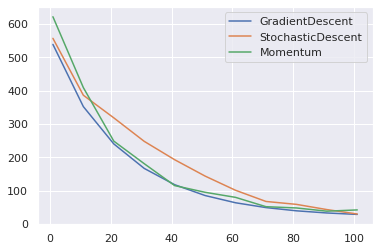

In [26]:
plt.figure()
for i in range(len(labels)):
    plt.plot([i for i in range(1, 102, 10)], values[labels[i]][:11], label=labels[i])

plt.legend()
plt.show()

At first iterations all gradients have simillar values and continue to decrease loss function as iterations grow.

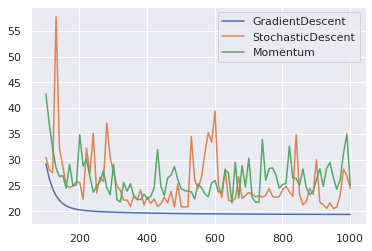

In [27]:
plt.figure()
for i in range(len(labels)):
    plt.plot([i for i in range(101, 1002, 10)], values[labels[i]][10:101], label=labels[i])

plt.legend()
plt.show()

In some point after continuing the prvious trend, The The full gradient option remains the same as the best one with lowest score. Other ones continue to unpredictable decrease and increase.

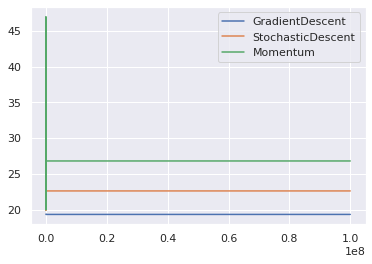

In [28]:
plt.figure()

for i in range(len(labels)):
    plt.plot([i for i in range(1001, 10**(MAX_ITER_DEG - 1) + 1, 10)], values[labels[i]][100:], label=labels[i])

plt.legend()
plt.show()

After reaching some point all gradients remains same, even if iterations become more and more